# Global constants

In [243]:
GRAIN_TYPE = 'Wheat'
GRAIN_TYPE = 'newWheatData'
# GRAIN_TYPE = 'Oats'
# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
# GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_t2_kcv_dnn_mc.h5'

In [244]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.4.1


In [245]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Helper functions

In [246]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

# 1. Load the Dataset
We are going to use one dataset from UCI Machine Learning Repository. You can download the Energy Efficient Dataset using the following link. You can use pandas to download and open the data set which is in excel format or load from your local machine.

In [247]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
df = df[df['Variety'] == 'KANSAS']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)


df.head()

From USDA:  ../Datasets/processed/newWheatData.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Phase/Attn
0,0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,-6.341975
1,1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,-11.142320
2,2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,-14.537729
3,3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,10.470049
4,4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,6.066299


# 2. Overview of data


In [248]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Phase/Attn
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,88.500000,11.252809,7.079775,15.855506,0.766912,18.213022,-4.895500,-619.726994,2.778247,0.460534,-0.454282
std,51.528309,3.626350,1.545775,3.247619,0.046552,5.912982,101.992501,206.226063,0.271266,0.163074,5.993995
min,0.000000,5.000000,4.400000,11.300000,0.669200,8.024200,-179.335000,-1102.044000,2.340000,0.220000,-14.537729
25%,44.250000,8.000000,6.500000,13.850000,0.727900,13.371500,-85.820500,-777.772250,2.561250,0.333750,-5.272155
50%,88.500000,11.000000,7.700000,16.330000,0.785900,17.923900,-9.202500,-595.838500,2.736000,0.435000,-0.589378
75%,132.750000,14.000000,7.700000,18.130000,0.808800,22.827025,79.064500,-447.857250,2.958750,0.595500,4.254243
max,177.000000,18.000000,8.900000,20.430000,0.842000,29.897000,179.046000,-264.103000,3.587000,0.793000,13.121642


In [249]:
# Dimension of the dataset
df.shape

(178, 12)

In [250]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Phase/Attn                0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [251]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Phase/Attn']]

df_targets = df[['M%', 'Density']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [252]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.15
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [253]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# Normalize the entire dataset (input features)
dataset_x_norm = scaler_input.transform(dataset_x)  # Use transform, NOT fit_transform

# Normalize the entire dataset (output targets)
dataset_y_norm = scaler_output.transform(dataset_y)  # Use transform, NOT fit_transform


# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining model

In [254]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  my_model = Sequential([
    
    layers.Dense(64, input_shape=(8,), activation='relu', 
                #  kernel_regularizer=regularizers.l2(0.01)
                 ),
    # layers.BatchNormalization(),  # Batch normalization layer
    # layers.Dropout(0.1),


    layers.Dense(64, activation='relu', 
                # kernel_regularizer=regularizers.l2(0.01)
                ),
    # layers.BatchNormalization(),  # Batch normalization layer
    # layers.Dropout(0.1),````

    layers.Dense(64, activation='relu', 
                # kernel_regularizer=regularizers.l2(0.01)
                ),
    # layers.BatchNormalization(),  # Batch normalization layer
    # layers.Dropout(0.2),
    
    layers.Dense(2, activation='linear')  # Output layer with 2 neurons for the two regression targets
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.0006)
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_540 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_541 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_542 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_543 (Dense)            (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________


## Running model with KCV

In [255]:
from sklearn.model_selection import KFold
import numpy as np

NUM_EPOCHS = 180
BATCH_SIZE = 10
K_FOLD_SPLITS = 10


# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y1 = y_train_norm[:,0]
Y2 = y_train_norm[:,1]
targets = (Y1, Y2)

X = X_train_norm

i = 0
arr_loss = list()
arr_rmse = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None

# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, valX = np.array(X[train_indices]), np.array(X[test_indices])
  trainY = np.vstack((Y1[train_indices], Y2[train_indices])).T
  valY = np.vstack((Y1[test_indices], Y2[test_indices])).T

  model = my_model()
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (valX, valY)
  )


  #testing on validation set process
  loss, rmse = model.evaluate(x = valX, y = valY, verbose=1)
  print(f"Loss = {loss}, rmse = {rmse}" )

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  arr_rmse.append(rmse)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)

####################### Iteration   0  #######################
Epoch 1/180
12/12 [==============================] - 0s 5ms/step - loss: 0.3367 - accuracy: 0.6419 - val_loss: 0.1336 - val_accuracy: 0.5385
Epoch 2/180
12/12 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.6727 - val_loss: 0.0830 - val_accuracy: 0.5385
Epoch 3/180
12/12 [==============================] - 0s 1ms/step - loss: 0.1036 - accuracy: 0.6374 - val_loss: 0.0569 - val_accuracy: 0.5385
Epoch 4/180
12/12 [==============================] - 0s 1ms/step - loss: 0.0864 - accuracy: 0.5772 - val_loss: 0.0428 - val_accuracy: 0.5385
Epoch 5/180
12/12 [==============================] - 0s 1ms/step - loss: 0.0656 - accuracy: 0.7735 - val_loss: 0.0361 - val_accuracy: 0.6154
Epoch 6/180
12/12 [==============================] - 0s 1ms/step - loss: 0.0585 - accuracy: 0.8612 - val_loss: 0.0298 - val_accuracy: 0.6154
Epoch 7/180
12/12 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy:

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No handles with labels found to put in legend.


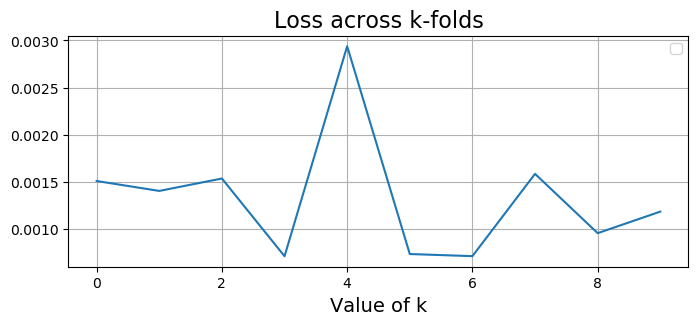

In [256]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

### Loss curves

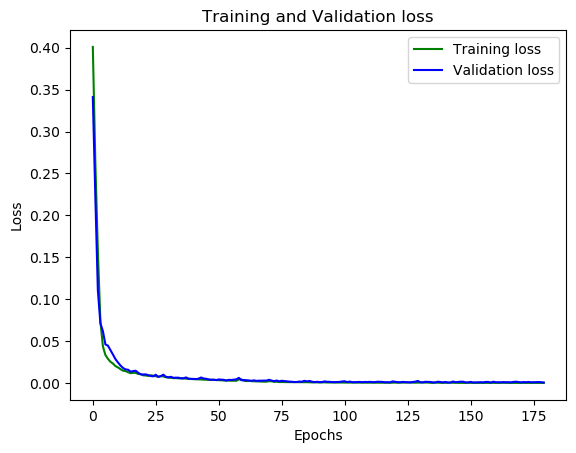

In [257]:
# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

In [258]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

Elapsed time: 0.0216 seconds
Maxval here is:  20.71111
Maxval here is:  0.842


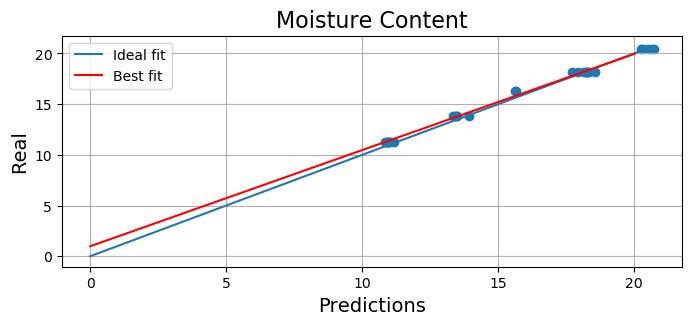

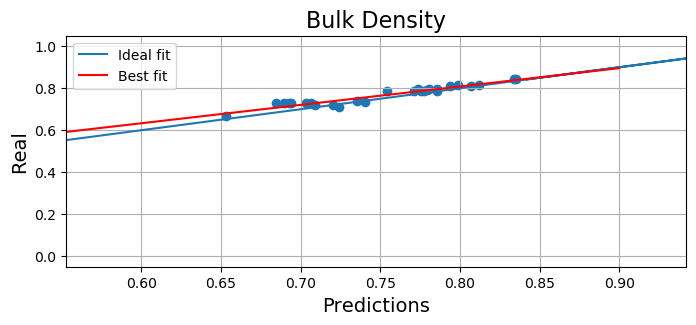

In [259]:
import time

start_time = time.time()
Y_pred_normalized = best_model.predict(X_test_norm)
end_time = time.time()
Y_pred_normalized_entire = best_model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = np.array(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Bulk Density
scatter_plot(trueValues=Y_actual[:,1], 
             predictions=Y_pred[:,1], 
             title="Bulk Density")
plt.xlim([min(min(Y_pred[:,1]), min(Y_actual[:,1]))-0.1, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1])
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_BD.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [260]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
# mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("{:#.4g}".format(mc_r2_score))

# BULK DENSITY
#   - R-squared
# bd_r2_score = r2_score(Y_actual[:, 1], Y_pred[:, 1])
bd_r2_score = calculate_r_squared(y_true=Y_actual[:, 1], y_pred=Y_pred[:, 1])
print("{:#.4g}".format(bd_r2_score))


0.9951
0.9256


### RMSE

In [261]:
from sklearn.metrics import mean_squared_error
from sigfig import round

#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_MC: ', "{0:.4g}".format(rmse_mc))

#BD
rmse_bd = np.sqrt(mean_squared_error(Y_actual[:, 1], Y_pred[:, 1]))
print('RMSE_BD: ', "{0:.4g}".format(rmse_bd))

RMSE_MC:  0.3492
RMSE_BD:  0.01954


Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [262]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))




R^2: 0.9894
Mean Squared Error:  0.1219
Mean Absolute Error:  0.2999
Min Absolute Error:  0.03189765930175881
Max Absolute Error:  0.7204142379760725


In [263]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9893
Mean Squared Error:  0.1126
Mean Absolute Error:  0.2758
Min Absolute Error:  0.0029547882080080967
Max Absolute Error:  1.054002838134764
